In [1]:
import mpramnist
from mpramnist.evfratovdataset import EvfratovDataset

import mpramnist.transforms as t
import mpramnist.target_transforms as t_t

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import logging
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 103

## Some info

The dataset has a pair of attributes:

merge_last_classes — determines whether the last two classes should be merged into one.

length_of_seq — determines which dataset to use. "23" refers to the dataset with sequences of length 23, and "33" refers to the dataset with sequences of length 33. The default is "23".

## Define set of transforms

In [ ]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.Reverse(0.5),

])
test_transform = t.Compose([ # test transforms are slightly different.
    t.Seq2Tensor(), 
    t.Reverse(0), # Reverse complementary transformation for all sequences with a probability of 0

])

## Merging last 2 classes

### 8 classes

The data initially has 8 labels. 

You can train the model on all 8 classes, but the number of instances in the last class is extremely small. 

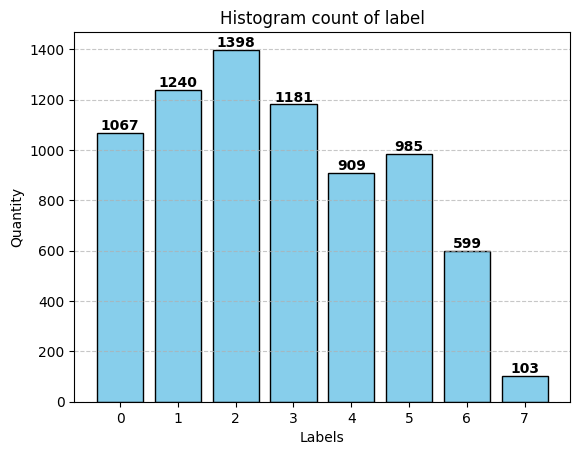

In [8]:
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set or use list
train_dataset.hist_plot()

Therefore, to balance class representation, we propose merging the last two classes into one.

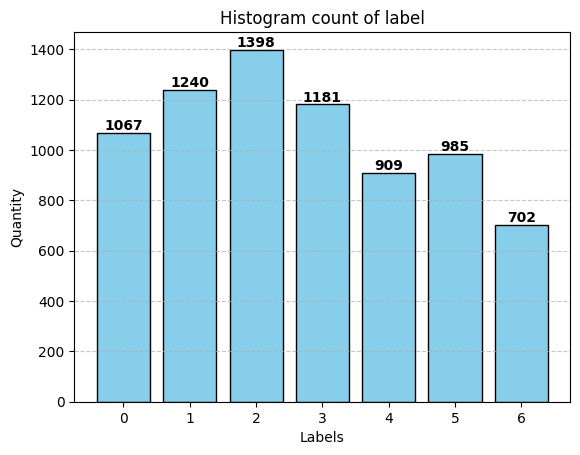

In [11]:
merge_last_classes = True

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set or use list
train_dataset.hist_plot()

## First, Lets work with sequences length of 23

The default value of *length_of_seq* is 23

In [13]:
length_of_seq = 23
train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set or use list
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                            transform=test_transform) # use "val" for default validation set or use list
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                             transform=test_transform) # use "test" for default test set or use list


In [14]:
N_CLASSES = train_dataset.n_classes

In [4]:
print(train_dataset)
print("------------")
print(val_dataset)
print("------------")
print(test_dataset)

Dataset EvfratovDataset of size 7482 (MpraDaraset)
    Number of datapoints: 7482
    Default split folds: {}
    Used split fold: train
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Sequence size: 23
    Number of samples: {}
------------
Dataset EvfratovDataset of size 1871 (MpraDaraset)
    Number of datapoints: 1871
    Default split folds: {}
    Used split fold: val
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Sequence size: 23
    Number of samples: {}
------------
Dataset EvfratovDataset of size 2339 (MpraDaraset)
    Number of datapoints: 2339
    Default split folds: {}
    Used split fold: test
    Scalar features: {}
    Vector features: {}
    Cell types: None
    Сell type used: None
    Target columns that can be used: {}
    Sequence size: 23
    Number of samples: {}


In [15]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score

from sklearn.preprocessing import label_binarize
from itertools import cycle

def calculate_auroc(y_score, y_true, n_classes, ax=None):

    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()

    y = label_binarize(y_true, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    lw = 1
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['orange', 'green', 'red', 'purple', 'brown', 'pink', 'blue', 'yellow', 'cyan']
    colors = cycle(colors[:n_classes])
    
    # Plot of a ROC curve for a specific class
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw= 0.5,label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for multi-class data')
    ax.legend(loc="lower right")

    return roc_auc_score(
        y_true,
        y_score,
        multi_class="ovr",
        average="macro",
    )

def calculate_aupr(y_score, y_true, n_classes, ax=None):
    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_pred = np.argmax(y_score, axis=1)
    y_true = y_true.cpu().numpy()
    
    df = pd.DataFrame({"predicted" : y_pred})
    
    ax.bar(np.arange(n_classes), np.bincount(y_pred, minlength=n_classes), color='skyblue', edgecolor='black')
    for i, count in enumerate(np.bincount(y_pred, minlength=n_classes)):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Quantity')
    ax.set_title('Histogram count of label')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')  
    print("Precision:", precision)
    print("Recall:", recall)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print("Accuracy:", accuracy)
    print("F1-score:", f1)

    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
    return pr_auc
    
def roc_auc(seq_model, loader, n_classes, figure=False):
    
    predictions = trainer.predict(seq_model, dataloaders=loader)
    
    targets = torch.cat([pred["y"] for pred in predictions])
    y_preds = torch.cat([pred["pred"] for pred in predictions])

    if figure:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Создаем фигуру с двумя subplot'ами в одной строке

    auroc = calculate_auroc(y_preds, targets, n_classes, ax1 if figure else None) 
    aupr = calculate_aupr(y_preds, targets, n_classes, ax2 if figure else None) 
    
    print("Test AUROC: %.4f"%(np.nanmean(auroc)))
    print("Test AUPR: %.4f"%(np.nanmean(aupr)))

    if figure:
        plt.tight_layout()  # Автоматическая настройка отступов между subplot'ами
        plt.show()

In [16]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 output_dim,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.output_dim = output_dim
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []

        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))

    def forward(self, x):
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

In [17]:
class FocalLoss(nn.Module):

    def __init__(self, alpha = 0.25, gamma = 2.0):
        super(FocalLoss, self).__init__()
        self.gamma = torch.tensor(gamma, dtype = torch.float32)
        self.alpha = alpha
        self.eps = 1e-6

    def forward(self, input, target):
        
        BCE_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
        pt = torch.exp(-BCE_loss) # prevents nans when probability 0
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

In [18]:
import pytorch_lightning as L
from torch.nn import functional as F
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch = 7, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        

        self.loss = torch.nn.CrossEntropyLoss().cuda() 
        self.lr = lr
        self.val_loss = []
        
        self.y_score = []
        self.y_true = []
        self.n_classes = out_ch
        self.train_loss = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        y = y.long()

        loss = self.loss(y_hat, y)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss.append(loss)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)
        
        self.y_score.append(y_hat)
        self.y_true.append(y)
        
    def on_validation_epoch_end(self):
        
        if len(self.train_loss) != 0:
            val_loss = torch.stack(self.val_loss, dim = 0).mean()
            
            y_score = torch.concat(self.y_score, dim = 0)
            y_true = torch.concat(self.y_true, dim = 0)
            
            auroc = self.calculate_auroc(y_score = y_score, y_true = y_true, n_classes = self.n_classes) 
            aupr = self.calculate_aupr(y_score = y_score, y_true = y_true, n_classes = self.n_classes) 
            
            train_loss = torch.stack(self.train_loss, dim = 0).mean()
        
            res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
            res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)

            res_str += ' {}: {:.5f} |'.format("val_auc_roc", auroc)
            res_str += ' {}: {:.5f} |'.format("val_auc_pr", aupr)

            res_str += ' {}: {:.5f} |'.format("train_loss", train_loss)
            
            border = '-'*len(res_str)
            print("\n".join(['',border, res_str, border,'']))
            self.val_loss.clear()

            self.y_score.clear()
            self.y_true.clear()
    
            self.train_loss.clear()

        return None

    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat, y)
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)

    def calculate_auroc(self, y_score, y_true, n_classes):

        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        
        y_true = y_true.cpu().numpy()
        
        return roc_auc_score(
            y_true,
            y_score,
            multi_class="ovr",
            average="macro",
        )

    def calculate_aupr(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_pred = np.argmax(y_score, axis=1)
        y_true = y_true.cpu().numpy()
        
        arr = []
        for i in range(n_classes):
            arr.append(y_pred.tolist().count(i))
        print(arr)
        
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')  
        print("Precision:", precision)
        print("Recall:", recall)

        accuracy = accuracy_score(y_true, y_pred)

        f1 = f1_score(y_true, y_pred, average='macro')
        
        print("Accuracy:", accuracy)
        print("F1-score:", f1)

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
        return pr_auc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)          
        
        return {"y": y.squeeze().long().cpu().detach().float(), "pred": y_hat.cpu().detach().float()}

    def train_dataloader(self):
        return data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, pin_memory=True)

    def val_dataloader(self):
        return data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True)
    
    def test_dataloader(self):
        return data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 1e-2)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]


In [19]:
seq_model = Seq1Model(in_ch = 4, out_ch = N_CLASSES, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-21 14:32:22.739180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 14:32:22.754823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[112, 236, 409, 215, 0, 154, 809]
Precision: 0.2520499175036074
Recall: 0.2804825687751241
Accuracy: 0.2718346253229974
F1-score: 0.2261800589438941

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 2.09883 | val_auc_roc: 0.68293 | val_auc_pr: 0.26720 | train_loss: 1.73594 |
-----------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation: |                                                                                     | 0/? [00:00…

[243, 0, 725, 307, 0, 222, 374]
Precision: 0.27687474552215013
Recall: 0.3865607889646648
Accuracy: 0.3741314804917157
F1-score: 0.3121271800529494

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 1.49995 | val_auc_roc: 0.80737 | val_auc_pr: 0.39556 | train_loss: 1.61625 |
-----------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation: |                                                                                     | 0/? [00:00…

[309, 38, 340, 400, 264, 25, 495]
Precision: 0.34261262515876423
Recall: 0.3746552843289009
Accuracy: 0.34099412079102087
F1-score: 0.3033687954402838

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 1.52570 | val_auc_roc: 0.79871 | val_auc_pr: 0.38704 | train_loss: 1.47416 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[294, 334, 459, 296, 174, 288, 26]
Precision: 0.5037810362180999
Recall: 0.42417728267193194
Accuracy: 0.44307856761090325
F1-score: 0.41831319612559303

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 1.29805 | val_auc_roc: 0.84870 | val_auc_pr: 0.45963 | train_loss: 1.36210 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.


[323, 221, 429, 308, 181, 261, 148]
Precision: 0.5168022493405926
Recall: 0.5108320331669731
Accuracy: 0.5029396044895778
F1-score: 0.5073737341389595

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 4.00000 | val_loss: 1.20986 | val_auc_roc: 0.86851 | val_auc_pr: 0.50752 | train_loss: 1.26933 |
-----------------------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Precision: 0.4990399336173902
Recall: 0.49772057814593823
Accuracy: 0.48952543822146216
F1-score: 0.49521944155873526
Test AUROC: 0.8612
Test AUPR: 0.4954


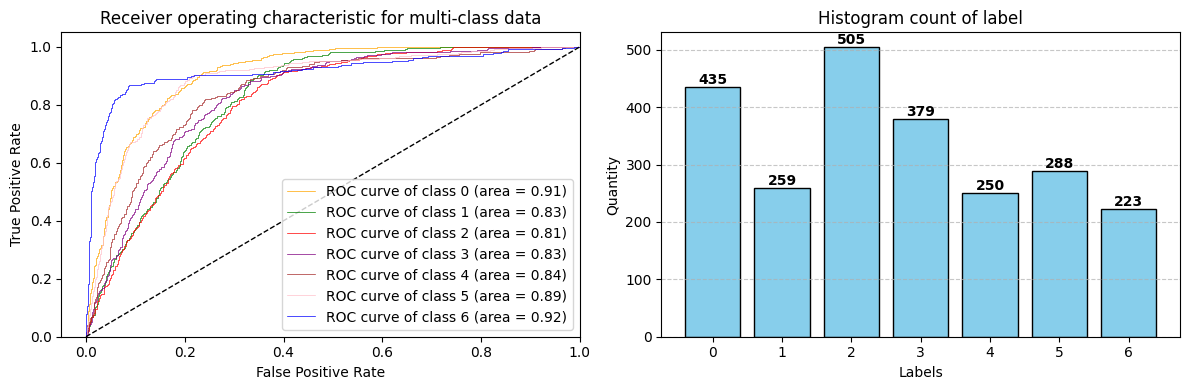

In [20]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
roc_auc(seq_model, test_loader, n_classes = N_CLASSES, figure = True)

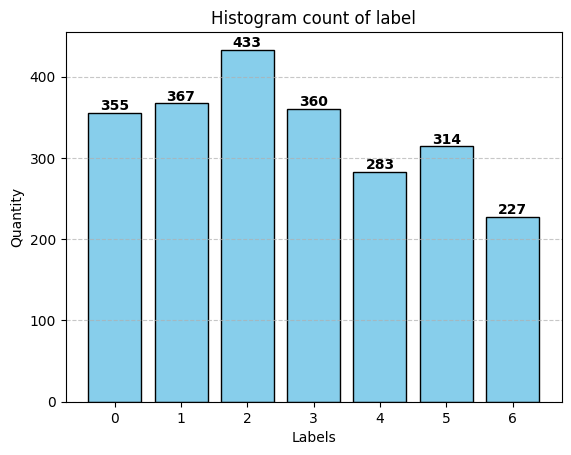

In [21]:
test_dataset.hist_plot()

## First, Lets try with sequences length of 33

In [29]:
length_of_seq = 33
merge_last_classes = False
train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes, 
                                length_of_seq = length_of_seq,
                              transform=train_transform) 
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                              length_of_seq = length_of_seq,
                            transform=test_transform) 
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                               length_of_seq = length_of_seq,
                             transform=test_transform) 
N_CLASSES = train_dataset.n_classes

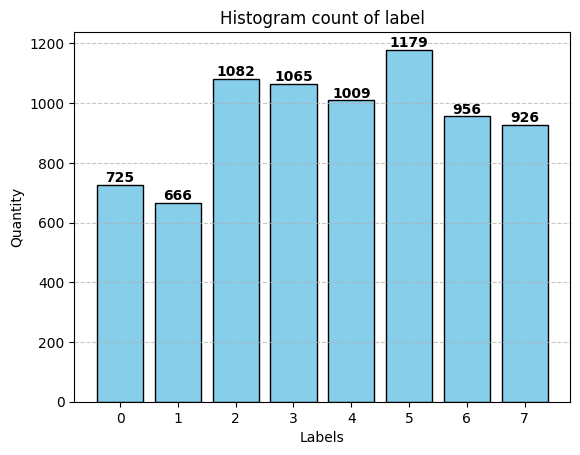

In [30]:
train_dataset.hist_plot()

In [34]:
seq_model = Seq1Model(in_ch = 4, out_ch = N_CLASSES, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    max_epochs=10,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | HumanLegNet      | 1.3 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.297     Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

[467, 2, 4, 493, 22, 270, 1, 708]
Precision: 0.1608886950640814
Recall: 0.24567568300669984
Accuracy: 0.25012709710218606
F1-score: 0.1639741856402668

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 1.86002 | val_auc_roc: 0.72076 | val_auc_pr: 0.26135 | train_loss: 1.93095 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[44, 0, 156, 573, 34, 398, 39, 659]
Precision: 0.23513157745075847
Recall: 0.2428516050652886
Accuracy: 0.2569626904887021
F1-score: 0.1827123367700017

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 1.80012 | val_auc_roc: 0.74228 | val_auc_pr: 0.28005 | train_loss: 1.85476 |
-----------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation: |                                                                                     | 0/? [00:00…

[186, 0, 641, 221, 90, 269, 479, 17]
Precision: 0.34833788418666856
Recall: 0.3029700446636371
Accuracy: 0.3063583815028902
F1-score: 0.25643735288178104

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 1.63411 | val_auc_roc: 0.78684 | val_auc_pr: 0.32377 | train_loss: 1.76500 |
-----------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation: |                                                                                     | 0/? [00:00…

[237, 0, 485, 84, 423, 346, 2, 326]
Precision: 0.28833507537802106
Recall: 0.36831455652458667
Accuracy: 0.37099316868102994
F1-score: 0.3066902886085757

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 1.56918 | val_auc_roc: 0.80917 | val_auc_pr: 0.35432 | train_loss: 1.67209 |
-----------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation: |                                                                                     | 0/? [00:00…

[364, 0, 150, 425, 6, 502, 118, 338]
Precision: 0.3054577571818452
Recall: 0.37246728732082407
Accuracy: 0.372044140830268
F1-score: 0.3050029037368132

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 4.00000 | val_loss: 1.50619 | val_auc_roc: 0.82858 | val_auc_pr: 0.38335 | train_loss: 1.59789 |
-----------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation: |                                                                                     | 0/? [00:00…

[236, 44, 296, 432, 0, 514, 28, 353]
Precision: 0.315955443093777
Recall: 0.36747136434129446
Accuracy: 0.371518654755649
F1-score: 0.30607644498191217

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 5.00000 | val_loss: 1.46216 | val_auc_roc: 0.83394 | val_auc_pr: 0.39857 | train_loss: 1.52893 |
-----------------------------------------------------------------------------------------------------------------



/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation: |                                                                                     | 0/? [00:00…

[238, 107, 387, 335, 142, 468, 91, 135]
Precision: 0.40023512250023724
Recall: 0.3755332811358675
Accuracy: 0.37519705727798214
F1-score: 0.3638921640583953

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 6.00000 | val_loss: 1.49204 | val_auc_roc: 0.82798 | val_auc_pr: 0.38982 | train_loss: 1.46216 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[221, 21, 350, 210, 293, 415, 136, 257]
Precision: 0.4368099267710939
Recall: 0.4289651609357362
Accuracy: 0.4330005254860746
F1-score: 0.40670938223628184

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 7.00000 | val_loss: 1.37484 | val_auc_roc: 0.85504 | val_auc_pr: 0.43340 | train_loss: 1.39009 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

[202, 54, 373, 222, 306, 357, 200, 189]
Precision: 0.4507782891729959
Recall: 0.4339431951346225
Accuracy: 0.43772990015764585
F1-score: 0.42834228019391307

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 8.00000 | val_loss: 1.37078 | val_auc_roc: 0.85632 | val_auc_pr: 0.43693 | train_loss: 1.30938 |
-----------------------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.


[214, 35, 378, 210, 264, 367, 207, 228]
Precision: 0.4416284969654387
Recall: 0.43520808620559764
Accuracy: 0.4393063583815029
F1-score: 0.42178257583107465

-----------------------------------------------------------------------------------------------------------------
| current_epoch: 9.00000 | val_loss: 1.36862 | val_auc_roc: 0.85672 | val_auc_pr: 0.44045 | train_loss: 1.26038 |
-----------------------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Precision: 0.4319640738526063
Recall: 0.4217159143863124
Accuracy: 0.42640874684608915
F1-score: 0.4108843025273242
Test AUROC: 0.8512
Test AUPR: 0.4313


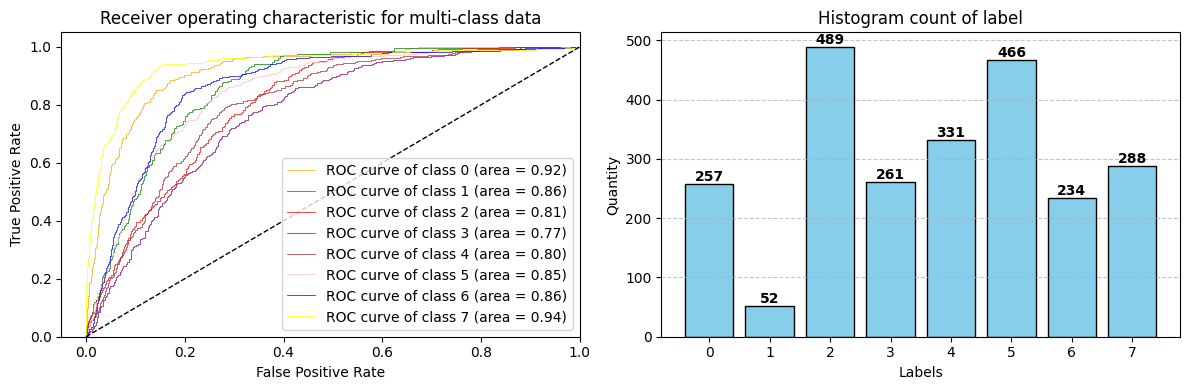

In [35]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
roc_auc(seq_model, test_loader, n_classes = N_CLASSES, figure = True)

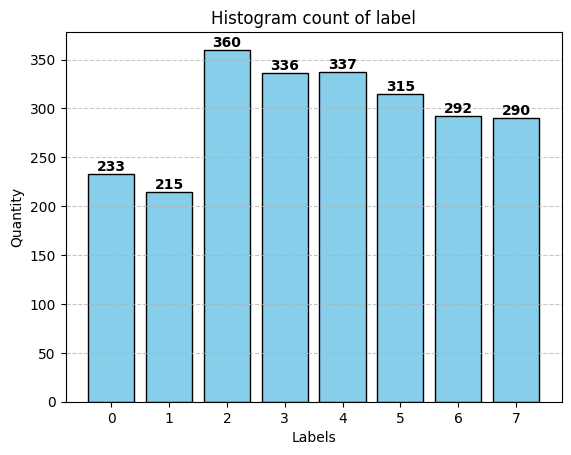

In [36]:
test_dataset.hist_plot()